# Data Preprocessing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [ ]:
# pip install -q -U keras-tuner

### Importing the dataset

In [ ]:
styleSilentShot = pd.read_excel('1.2 SilentSoundScale_asl_count30+.xlsx')
X = styleSilentShot.iloc[: , 1:-1].values # These are the predictor, independent variables (the 1:-1 excludes the first and last columns)
y = styleSilentShot.iloc[: , -1].values # These are the target variables (or classes, in this case)
styleSilentShot.head()

,Title,COUNTRY,ASL,RA,POV,INS,BCU,CU,MCU,MS,MLS,LS,VLS,Sound
0,10 Things I Hate About You,USA,6.7,58,4.0,2.0,64,224,82,37,36,53,3,1
1,"Adventures of Robin Hood, The",USA,5.0,0,0.0,0.0,3,53,71,77,109,111,76,1
2,"Affairs of Anatole, The",USA,8.0,23,16.0,9.0,33,26,89,141,136,70,5,0
3,Alley Cat,BRI,6.0,10,0.0,0.0,17,68,84,82,101,142,5,0
4,"Almost Perfect Affair, An",USA,4.2,64,12.0,7.0,70,199,93,51,26,51,9,1


In [ ]:
print(X)

[['USA' 6.7 58 ... 36 53 3]
 ['USA' 5.0 0 ... 109 111 76]
 ['USA' 8.0 23 ... 136 70 5]
 ...
 ['GER' 7.7 52 ... 99 66 40]
 ['GER' 8.0 14 ... 123 243 26]
 ['GER' 27.0 0 ... 83 396 21]]


In [ ]:
print(y)

[1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1
 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1
 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1
 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1
 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1
 1 1 1 1 0 0]


### Encoding categorical data

One Hot Encoding the "COUNTRY" column

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [ ]:
print(X)

[[0.0 0.0 0.0 ... 36 53 3]
 [0.0 0.0 0.0 ... 109 111 76]
 [0.0 0.0 0.0 ... 136 70 5]
 ...
 [0.0 0.0 1.0 ... 99 66 40]
 [0.0 0.0 1.0 ... 123 243 26]
 [0.0 0.0 1.0 ... 83 396 21]]


### Splitting the dataset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train) # Feature scale even the one-hot-encoded variables for deep learning
X_test = sc.transform(X_test) # Not fitted to the test set to avoid information leakage
                              # Using the same scaler (fit mean and std dev) as the training data because 
                              # the test data is "unavailable"

In [ ]:
print(X_test)

[[-0.47249954 -0.33121691 -0.4359418  ... -0.79984982 -0.62704295
   0.24163263]
 [ 2.11640418 -0.33121691 -0.4359418  ... -0.72352855 -0.64368059
  -0.56963608]
 [ 2.11640418 -0.33121691 -0.4359418  ...  0.34496924  0.07173796
  -0.68553161]
 ...
 [-0.47249954 -0.33121691 -0.4359418  ... -0.20835997  0.4544037
  -0.49237239]
 [-0.47249954  3.01916952 -0.4359418  ...  0.03968416  1.06999641
   0.55068738]
 [-0.47249954 -0.33121691 -0.4359418  ... -0.26560092 -1.1760851
  -0.76279529]]


# The Random Search ANN

## Initialise the RS ANN

In [ ]:
# Tensorboard
%load_ext tensorboard
import datetime, os

# Training parameters
MAX_EPOCHS = 100
BATCH_SIZE = 32

# Early Stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Performance metrics dictionary
performance_metrics = {
    'best_val_epoch': [],
    'training_loss': [],
    'training_auc': [],
    'validation_loss': [],
    'validation_auc': [],
    'evaluation_loss': [],
    'evaluation_auc': []
}

In [ ]:
# Random search performance dataframe
RS_performance_df=pd.DataFrame(performance_metrics)

# START Training for loop

for i in range(1, 31):

    # Initialise the Ransom Search model:
    rs_model = tf.keras.models.Sequential()
    # Add the input and hidden layers
    rs_model.add(tf.keras.layers.Dense(units=22, kernel_regularizer='l2', activation='relu'))
    # Add the output layer
    rs_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    # Specify the learning rate based on the tuner results
    rs_learning_rate=0.01
    rs_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=rs_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['AUC'])

    # Define new TensorBoard directory to keep track of each run
    logdir = os.path.join("training_logs_random_search", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    # Fit the model
    history = rs_model.fit(X_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=MAX_EPOCHS, 
              validation_split=0.3,
              callbacks=[stop_early, tensorboard_callback])

    # list all data in history
    # print(history.history.keys())
    # print(history.history['loss'][-1], history.history['auc'][-1], history.history['val_loss'][-1], history.history['val_auc'][-1])

    # store the best_epoch value
    val_auc_per_epoch = history.history['val_auc']
    best_epoch = val_auc_per_epoch.index(max(val_auc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))

    # Evaluate the model
    eval_result = rs_model.evaluate(X_test, y_test)
    print("[test loss, test auc]:", eval_result)
    # print(eval_result[0], eval_result[1])

    # store the training, validation and test data in the RS_performance_df
    trial_performance_row = [
                            best_epoch,
                            history.history['loss'][-1],
                            history.history['auc'][-1],
                            history.history['val_loss'][-1],
                            history.history['val_auc'][-1],
                            eval_result[0],
                            eval_result[1]
                            ]
    # Add the performance row to the dataframe
    RS_performance_df.loc['run_' + str(i)] = trial_performance_row

# Outside the loop

Epoch 1/100
6/6 [==============================] - 2s 152ms/step - loss: 0.9026 - auc: 0.6771 - val_loss: 0.6946 - val_auc: 0.8274
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6560 - auc: 0.8162 - val_loss: 0.5792 - val_auc: 0.8796
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5537 - auc: 0.8821 - val_loss: 0.5366 - val_auc: 0.8896
Epoch 4/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5390 - auc: 0.8712 - val_loss: 0.5063 - val_auc: 0.8944
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5009 - auc: 0.8901 - val_loss: 0.4826 - val_auc: 0.9015
Epoch 6/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4514 - auc: 0.9213 - val_loss: 0.4680 - val_auc: 0.9063
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4008 - auc: 0.9388 - val_loss: 0.4567 - val_auc: 0.9130
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4140 - auc: 0.9

## Inspect the model performance

In [ ]:
RS_performance_df

,best_val_epoch,training_loss,training_auc,validation_loss,validation_auc,evaluation_loss,evaluation_auc
run_1,49.0,0.194096,0.996063,0.335356,0.949259,0.440843,0.911742
run_2,31.0,0.206975,0.993645,0.342523,0.942222,0.417948,0.916477
run_3,27.0,0.212122,0.992057,0.344489,0.948889,0.432815,0.916667
run_4,25.0,0.223945,0.989225,0.355008,0.937778,0.423039,0.903977
run_5,32.0,0.211177,0.992471,0.345178,0.943333,0.434976,0.909470
run_6,39.0,0.214913,0.990468,0.332837,0.941481,0.420295,0.916856
run_7,30.0,0.221607,0.988811,0.357576,0.933704,0.419531,0.916667
run_8,37.0,0.208541,0.993853,0.340035,0.943333,0.432524,0.915152
run_9,21.0,0.247286,0.982387,0.366857,0.925185,0.439411,0.895833
run_10,16.0,0.232407,0.987636,0.351437,0.937037,0.421020,0.912689


In [ ]:
#Inspect the training tensorboard
%tensorboard --logdir training_logs_random_search 

## Document results

Save the Random Search performance dataframe to an excel file

In [ ]:
RS_performance_df.to_excel('RS_30_trials_perfomance_results.xlsx')

Create evaluation performance box plot

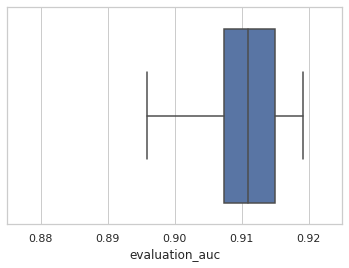

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

ax = sns.boxplot(x=RS_performance_df["evaluation_auc"])
ax.set(xlim=(0.875, 0.925))

figure = ax.get_figure()    
figure.savefig('RS_boxplot.png', dpi=500)

# The Bayesian Optimisation ANN

## Initialise the BO ANN

In [ ]:
# Bayesian optimisation performance dataframe
BO_performance_df=pd.DataFrame(performance_metrics)

# START Training for loop

for i in range(1, 31):

    # Initialise the BO model:
    bo_model = tf.keras.models.Sequential()
    # Add the input and hidden layers
    bo_model.add(tf.keras.layers.Dense(units=28, kernel_regularizer='l2', activation='relu'))
    # Add the output layer
    bo_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    # Specify the learning rate based on the tuner results
    bo_learning_rate=0.01
    bo_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=bo_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['AUC'])

    # Define new TensorBoard directory to keep track of each run
    logdir = os.path.join("training_logs_bayesian_optimisation", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    # Fit the model
    history = bo_model.fit(X_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=MAX_EPOCHS, 
              validation_split=0.3,
              callbacks=[stop_early, tensorboard_callback])

    # list all data in history
    # print(history.history.keys())
    # print(history.history['loss'][-1], history.history['auc'][-1], history.history['val_loss'][-1], history.history['val_auc'][-1])

    # store the best_epoch value
    val_auc_per_epoch = history.history['val_auc']
    best_epoch = val_auc_per_epoch.index(max(val_auc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))

    # Evaluate the model
    eval_result = bo_model.evaluate(X_test, y_test)
    print("[test loss, test auc]:", eval_result)
    # print(eval_result[0], eval_result[1])

    # store the training, validation and test data in the BO_performance_df
    trial_performance_row = [
                            best_epoch,
                            history.history['loss'][-1],
                            history.history['auc'][-1],
                            history.history['val_loss'][-1],
                            history.history['val_auc'][-1],
                            eval_result[0],
                            eval_result[1]
                            ]
    # Add the performance row to the dataframe
    BO_performance_df.loc['run_' + str(i)] = trial_performance_row

# Outside the loop:

Epoch 1/100
6/6 [==============================] - 1s 97ms/step - loss: 0.8820 - auc: 0.5449 - val_loss: 0.7297 - val_auc: 0.7144
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6870 - auc: 0.7447 - val_loss: 0.6162 - val_auc: 0.8078
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5451 - auc: 0.8786 - val_loss: 0.5570 - val_auc: 0.8485
Epoch 4/100
6/6 [==============================] - 0s 14ms/step - loss: 0.4766 - auc: 0.9063 - val_loss: 0.5193 - val_auc: 0.8759
Epoch 5/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4413 - auc: 0.9316 - val_loss: 0.4861 - val_auc: 0.8878
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.3887 - auc: 0.9375 - val_loss: 0.4648 - val_auc: 0.8922
Epoch 7/100
6/6 [==============================] - 0s 12ms/step - loss: 0.4054 - auc: 0.9317 - val_loss: 0.4412 - val_auc: 0.9081
Epoch 8/100
6/6 [==============================] - 0s 12ms/step - loss: 0.3861 - auc: 0.94

## Inspect the model performance

In [ ]:
# Display the BO performance dataframe
BO_performance_df

,best_val_epoch,training_loss,training_auc,validation_loss,validation_auc,evaluation_loss,evaluation_auc
run_1,36.0,0.192308,0.995441,0.368081,0.937407,0.432936,0.913068
run_2,35.0,0.196875,0.993231,0.340388,0.942593,0.445135,0.908333
run_3,33.0,0.196058,0.993576,0.343784,0.945926,0.457432,0.905492
run_4,30.0,0.195851,0.996063,0.358339,0.940741,0.449377,0.905871
run_5,30.0,0.214943,0.993922,0.351077,0.940741,0.435407,0.911742
run_6,20.0,0.247668,0.986255,0.365792,0.927778,0.427330,0.903220
run_7,27.0,0.215000,0.991988,0.355015,0.940741,0.445229,0.903598
run_8,35.0,0.196899,0.994682,0.363785,0.938519,0.458931,0.896212
run_9,38.0,0.194440,0.994267,0.371424,0.939630,0.435412,0.911932
run_10,26.0,0.223809,0.990261,0.353386,0.937407,0.434078,0.907576


In [ ]:
#Inspect the training tensorboard
%tensorboard --logdir training_logs_bayesian_optimisation 

## Document results

Save the Random Search performance dataframe to an excel file

In [ ]:
BO_performance_df.to_excel('BO_30_trials_perfomance_results.xlsx')

Create evaluation performance box plot

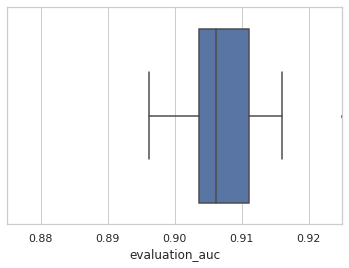

In [ ]:
ax = sns.boxplot(x=BO_performance_df["evaluation_auc"])
ax.set(xlim=(0.875, 0.925))

figure = ax.get_figure()    
figure.savefig('BO_boxplot.png', dpi=500)

# Model comparison

In this section, the models using on the Adam optimiser are compared to the models using on the L-BFGS-B optimiser. The L-BFGS-B models were constructed in the **ANN 5x2 cv t-test** python script for comparative purposes and also in Orange (which is also based on the scikit learn python implementation of the model) to obtain training and testing results.

These results were tabulated in the **L-BFGS-B vs Adam boxplot data test auc.xlsx** document, which is also contained in this GitHub repository.

## Boxplots comparison

In [ ]:
optimiserComparisonBoxplots = pd.read_excel('L-BFGS-B vs Adam boxplot data test auc.xlsx')
optimiserComparisonBoxplots.head()

,Test AUC,Neurons in hidden layer,Optimiser
0,0.962,22,L-BFGS-B
1,0.960,22,L-BFGS-B
2,0.965,22,L-BFGS-B
3,0.954,22,L-BFGS-B
4,0.958,22,L-BFGS-B


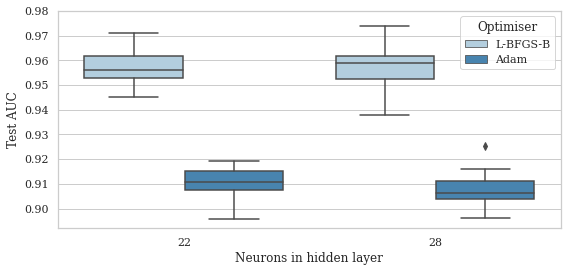

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})
fig_dims = (9, 4)
fig, ax = plt.subplots(figsize = fig_dims)

ax = sns.boxplot(x="Neurons in hidden layer", y="Test AUC", hue="Optimiser",
                 data=optimiserComparisonBoxplots, palette="Blues")
ax.set(ylim=(0.892, 0.98))

figure = ax.get_figure()    
figure.savefig('FourModelsComparisonBoxplots.png', dpi=500)

Compare only the two models that have 22 neurons in the hidden layer

In [ ]:
# Construct a datframe containing only the random search 22-neuron models data
randomSearchComparisonBoxplots = optimiserComparisonBoxplots[optimiserComparisonBoxplots['Neurons in hidden layer'] != 28]
randomSearchComparisonBoxplots.head()

,Test AUC,Neurons in hidden layer,Optimiser
0,0.962,22,L-BFGS-B
1,0.960,22,L-BFGS-B
2,0.965,22,L-BFGS-B
3,0.954,22,L-BFGS-B
4,0.958,22,L-BFGS-B


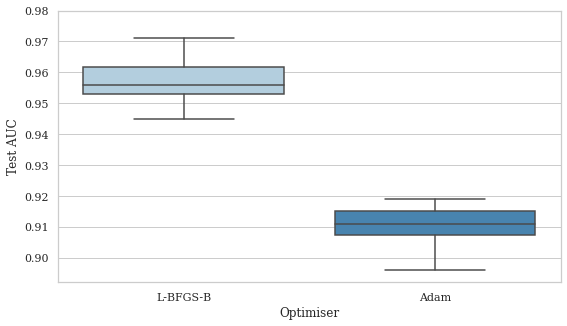

In [ ]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})
fig_dims = (9, 5)
fig, ax = plt.subplots(figsize = fig_dims)

ax = sns.boxplot(x="Optimiser", y="Test AUC",
                 data=randomSearchComparisonBoxplots, palette="Blues")
ax.set(ylim=(0.892, 0.98))

figure = ax.get_figure()    
figure.savefig('RandomSearchComparisonBoxplots.png', dpi=500)

In [ ]:
# Construct a datframe containing only the bayesian optimisation 28-neuron models data
BayesComparisonBoxplots = optimiserComparisonBoxplots[optimiserComparisonBoxplots['Neurons in hidden layer'] != 22]
BayesComparisonBoxplots.head()

,Test AUC,Neurons in hidden layer,Optimiser
60,0.951,28,L-BFGS-B
61,0.953,28,L-BFGS-B
62,0.960,28,L-BFGS-B
63,0.955,28,L-BFGS-B
64,0.947,28,L-BFGS-B


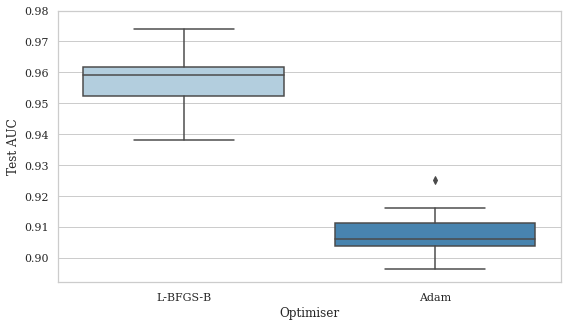

In [ ]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})
fig_dims = (9, 5)
fig, ax = plt.subplots(figsize = fig_dims)

ax = sns.boxplot(x="Optimiser", y="Test AUC",
                 data=BayesComparisonBoxplots, palette="Blues")
ax.set(ylim=(0.892, 0.98))

figure = ax.get_figure()    
figure.savefig('BayesComparisonBoxplots.png', dpi=500)

In [ ]:
# Construct a datframe containing only the bayesian optimisation 28-neuron models data
AdamComparisonBoxplots = optimiserComparisonBoxplots[optimiserComparisonBoxplots['Optimiser'] != 'L-BFGS-B']
AdamComparisonBoxplots.head()

,Test AUC,Neurons in hidden layer,Optimiser
30,0.911742,22,Adam
31,0.916477,22,Adam
32,0.916667,22,Adam
33,0.903977,22,Adam
34,0.909470,22,Adam


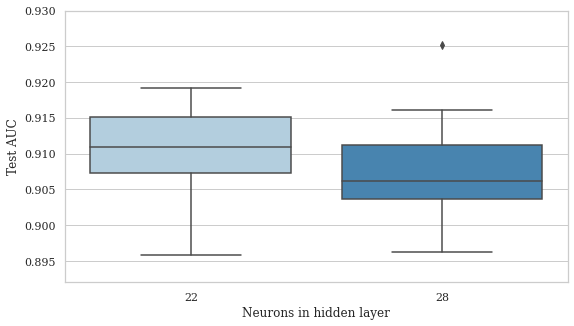

In [ ]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})
fig_dims = (9, 5)
fig, ax = plt.subplots(figsize = fig_dims)

ax = sns.boxplot(x="Neurons in hidden layer", y="Test AUC",
                 data=AdamComparisonBoxplots, palette="Blues")
ax.set(ylim=(0.892, 0.93))

figure = ax.get_figure()    
figure.savefig('AdamComparisonBoxplots.png', dpi=500)